In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import ot
import sys
import anndata

In [8]:
citeseq = anndata.read_h5ad("/workspace/ImputationOT/citeseq_processed-001.h5ad")

/opt/conda/envs/ot/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [18]:
X = citeseq.X
print("Matrix Shape:", X.shape)
print("Number of Non-zero Elements:", X.nnz)
print("Density:", X.nnz / (X.shape[0] * X.shape[1]))
print("Minimum Value:", X.min())
print("Maximum Value:", X.max())
print("Mean Value without zeros:", X[X != 0].mean())

X = X.toarray()

Matrix Shape: (90261, 14087)
Number of Non-zero Elements: 141495252
Density: 0.11128156164731894
Minimum Value: 0.0
Maximum Value: 21078940.0
Mean Value without zeros: 13.447416


In [32]:
X = np.log1p(X)
print("Matrix Shape:", X.shape)
print("Minimum Value:", X.min())
print("Maximum Value:", X.max())
print("Mean Value without zeros:", X[X != 0].mean())

Matrix Shape: (90261, 14087)
Minimum Value: 0.0
Maximum Value: 1.3565502
Mean Value without zeros: 0.48513538


In [25]:
for _ in range(200):
    col = np.random.randint(0, 14087)
    print(col, int(X[:, col].max()))

10408 94
10035 115
4348 25
13876 66
2910 52
9411 59
8071 95
13622 111
13559 77
12744 65
2620 31
4617 43
1781 84
4941 6
13673 34
881 182
3105 41
5503 108
1061 34
8625 56
9628 48
5682 415
2330 6
7702 5
9936 222
3520 126
6857 44
12549 28
12438 9
11481 84
11458 98
11265 31
9365 129
1421 41
11273 22
5905 28
7959 58
13353 141
11279 85
9149 66
6980 30
6827 92
4560 18
12594 56
533 44
11289 55
11899 123
30 112
6390 51
13994 4
13436 175
7515 37
8011 225
9625 15
6208 34
8726 3
5129 49
4400 14
11372 70
9369 25
4934 43
4578 44
7217 15
5486 20
9861 82
13960 3
9519 187
3596 92
6726 86
11280 289
8702 109
11415 8
12398 5
12808 132
4671 114
4373 14
6033 96
8584 31
7675 14
8530 65
5265 6
13666 81
12385 37
2426 172
2350 7
1233 580
6686 5090
12486 19
7231 154605
515 77
11526 72
7818 56
12468 66
3609 82
12274 52
10875 70
2395 447
12884 21
1362 3
5709 54
13089 103
5057 32
11489 68
8658 99
6493 242
11381 54
8645 42
7114 104
6978 90
1659 109
12537 128
8966 31
11192 166
1107 47
8625 56
235 26
12547 22
11419 55


In [29]:
for i in range(10000):
    print(X[i, -1])

0.6068599
1.9254438
0.4064944
3.9356906
0.6951424
0.58961576
0.15488395
1.6096839
0.6552994
0.32237262
0.89592695
0.6313104
0.30876678
0.31746072
0.961658
0.37979424
0.35820204
0.47921124
1.9133613
0.96951187
0.42072138
3.1811266
0.25605533
1.1051693
0.68747747
0.32962734
1.5875794
1.1547515
0.38853896
0.9159449
0.7300486
1.4904072
0.30386993
2.036947
0.4004995
0.3307294
0.34404662
0.34675062
0.5429999
0.30142996
0.3075757
2.2176876
0.4913038
0.68791586
1.069534
1.8083112
2.0842729
2.3870382
0.30827796
0.18783152
0.22696204
0.48846942
1.6382867
0.4819087
0.56264293
0.21158019
1.8500056
0.50074893
2.13128
1.6362532
0.4101251
1.9780511
2.1651888
0.114864424
0.34660557
1.7601777
0.18817681
0.83201665
1.0716105
3.4237165
2.3038213
0.6583227
0.79235965
0.48322725
0.23362409
0.9737175
0.72419
0.7106118
0.34396097
0.8037868
2.019596
0.54684865
0.5075439
0.49758315
0.30500537
0.0
0.68394315
0.42915905
0.48516667
1.7932478
0.72130936
0.2035652
1.2952055
1.7903694
0.5531688
0.900764
0.52226806
1

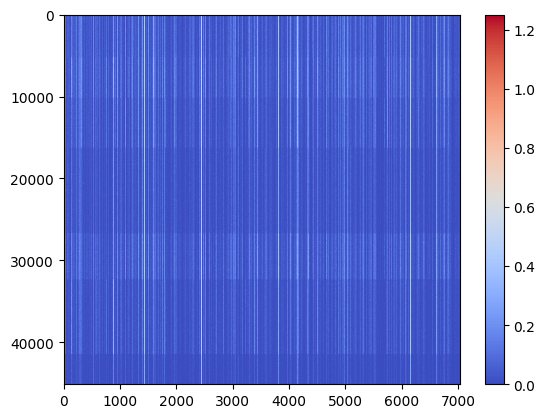

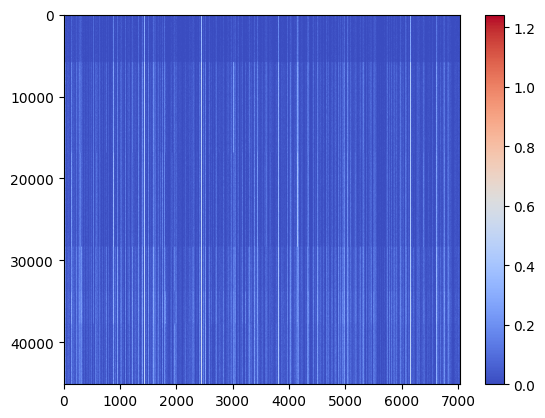

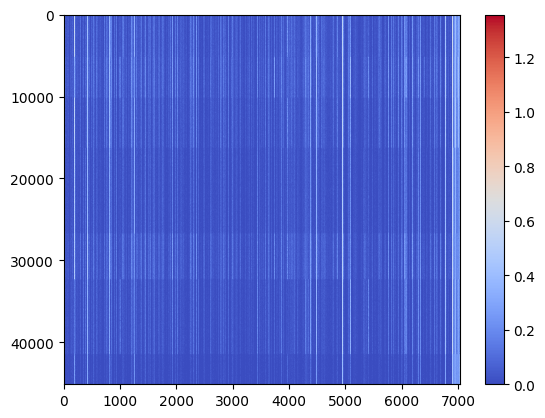

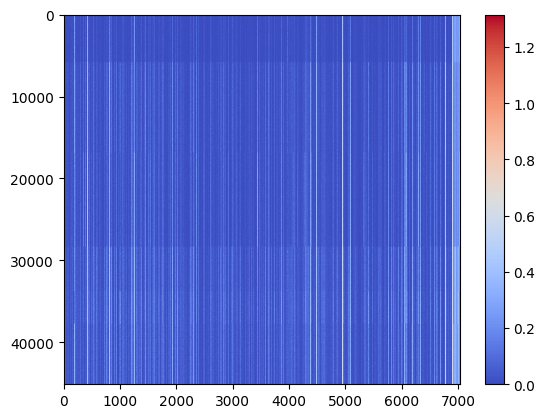

In [33]:
cmap = plt.get_cmap('coolwarm')

plt.imshow(X[:90261 // 2, :14087 // 2], cmap=cmap, aspect='auto')
plt.colorbar()
plt.show()

plt.imshow(X[90261 // 2:, :14087 // 2], cmap=cmap, aspect='auto')
plt.colorbar()
plt.show()

plt.imshow(X[:90261 // 2, 14087 // 2:], cmap=cmap, aspect='auto')
plt.colorbar()
plt.show()

plt.imshow(X[90261 // 2:, 14087 // 2:], cmap=cmap, aspect='auto')
plt.colorbar()
plt.show()

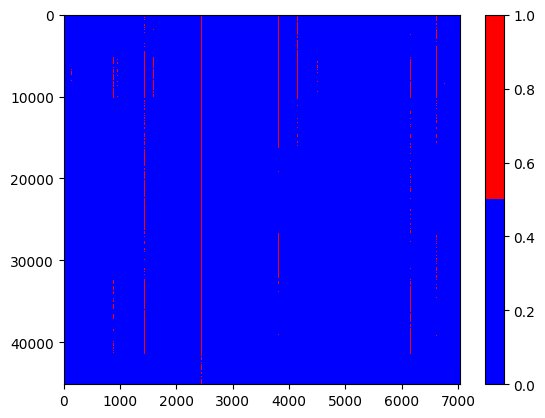

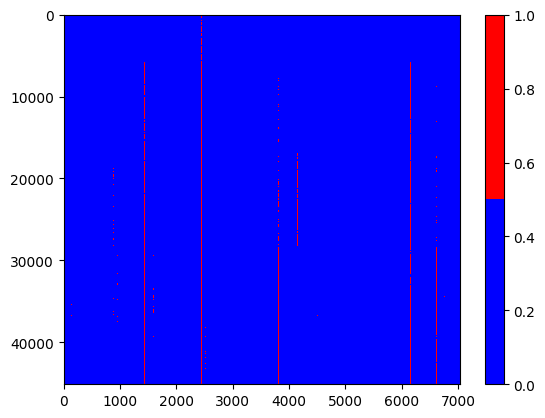

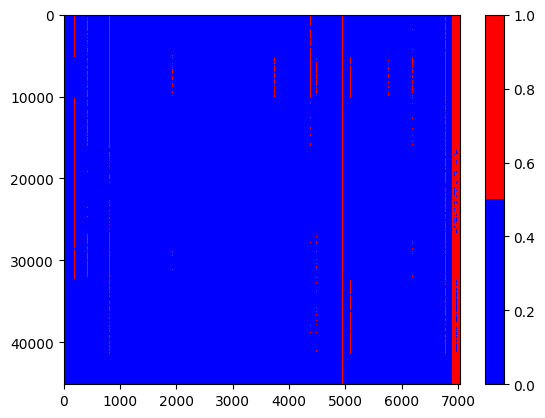

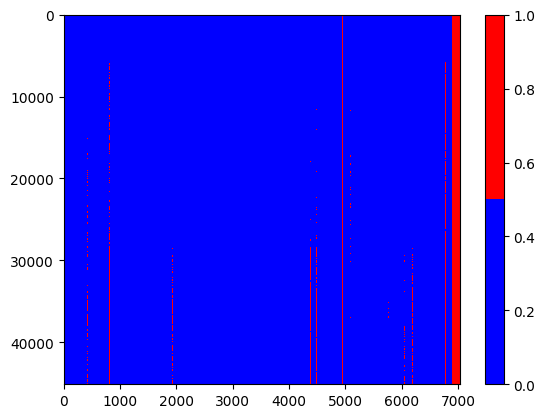

In [53]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['blue', 'red'])  # 等于0的数据用蓝色，大于0的数据用红色

plt.imshow(X[:90261 // 2, :14087 // 2], cmap=cmap, aspect='auto')
plt.colorbar()
plt.show()

plt.imshow(X[90261 // 2:, :14087 // 2], cmap=cmap, aspect='auto')
plt.colorbar()
plt.show()

plt.imshow(X[:90261 // 2, 14087 // 2:], cmap=cmap, aspect='auto')
plt.colorbar()
plt.show()

plt.imshow(X[90261 // 2:, 14087 // 2:], cmap=cmap, aspect='auto')
plt.colorbar()
plt.show()